In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

%matplotlib inline


In [9]:
data = loadmat('data.mat')
lab = loadmat('label.mat')

In [20]:
data = data['data'].T
label = lab['trueLabel'][0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

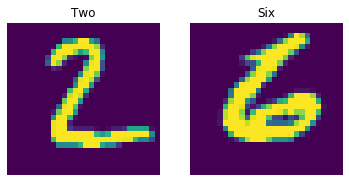

In [35]:
ex_2 = np.flip(np.rot90(data[0,:].reshape(28,28), -1), 1)
ex_6 = np.flip(np.rot90(data[-1,:].reshape(28,28), -1), 1)


plt.subplot(1, 2, 1)
plt.title("Two")
plt.imshow(ex_2)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Six")
plt.imshow(ex_6)
plt.axis("off")
plt.show()

In [36]:
def initialization(X, K):
    m,n=X.shape
    pis = np.array([.5,.5])
    idx = np.random.randint(n, size=n)
    mus = np.zeros(shape=(K,n))
    for k in range(K):
        idx = np.random.randint(m, size=int(m/K))
        x = X[idx]
        mu = x.mean(axis=0)
        mus[k] = mu
    sigmas = np.array([np.identity(n)]*K)
    return pis, mus, sigmas

def get_n(x,sigma,mu, r=35):
    U, S, V = np.linalg.svd(sigma, 
      full_matrices=False,
      compute_uv=True)
    lambd = S[:r]
    U = U[:,:r]
    mu_approx = np.dot(U.T,mu)
    x_approx = np.dot(U.T, x)
    det = np.prod(lambd)
    xm = x_approx - mu_approx
    exponent = np.exp(-.5*np.dot(np.dot(xm.T,np.diag(lambd**-1)), xm))
    ll = np.log(exponent) + np.log(np.sqrt(det))
    n = exponent/np.sqrt(det)
    return n, ll

def get_mus(X,expectations):
    n,m=X.shape
    K = expectations.shape[1]
    mus = np.zeros(shape=(K,m))
    for k in range(K):
        tau = expectations[:,k]
        numerator = np.zeros(shape=(m))
        for i in range(n):
            x_i=X[i,:]
            tau_i = tau[i]
            numerator += tau_i * x_i
        mu = numerator / np.sum(tau)
        mus[k] = mu
    return mus

def get_sigmas(X,expectations,mus):
    n,m=X.shape
    K = expectations.shape[1]
    sigmas = np.zeros((K, m, m))
    for k in range(K):
        tau = expectations[:,k]
        mu = mus[k,:]
        numerator = np.zeros(shape=(m,m))
        for i in range(n):
            x_i=X[i,:]
            tau_i = tau[i]
            x_i_minus_mu = (x_i - mu).reshape(m,1)
            numerator += tau_i*np.dot(x_i_minus_mu,x_i_minus_mu.T)
        sigmas[k] = numerator / np.sum(tau)
            
    return sigmas

In [37]:
X= data[:,:]
K = 2
pis, mus, sigmas = initialization(X, K)

In [ ]:
max_iter=25
m,n = X.shape
log_likelihoods = []
mus_list = []
for z in range(max_iter):
    N = np.zeros(shape=(m, K))
    taus = np.zeros(shape=(m, K))
    k = 0
    log_likelihood = 0
    # expecatation part
    for pi, mu, sigma in zip(pis,mus, sigmas):
        en = np.apply_along_axis(get_n, 1, X, sigma, mu, r=50)
        N[:,k] = en[:,0]
        k+=1
        log_likelihood += np.sum(en[:,1])
    log_likelihoods.append(log_likelihood)
    print(log_likelihood)
    n_sum = N.sum(axis = 1)
    taus = N*pis / n_sum.reshape(m,1)
    # maximization part
    pis = taus.sum(axis=0)/m
    mus_list.append(mus)
    mus = get_mus(X,taus)
    sigmas = get_sigmas(X,taus,mus)

In [ ]:
pis

In [ ]:
examples = [("2",mus_list[1]), ("7", mus_list[6]),("8",mus_list[7]),("9", mus_list[8]),(str(len(mus_list)),mus_list[-1])]


for mus_ in examples:
    title, mus = mus_
    t1 = np.flip(np.rot90(mus[0,:].reshape(28,28), -1), 1)
    t2 = np.flip(np.rot90(mus[1,:].reshape(28,28), -1), 1)
    plt.subplot(1, 2, 1)
    plt.title("Iteration: {}".format(title))
    plt.imshow(t1)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Iteration: {}".format(title))
    plt.imshow(t2)
    plt.axis("off")
    plt.show()

In [ ]:
import seaborn as sns; sns.set()
import pandas as pd
ax = sns.lineplot(data=pd.Series(log_likelihoods))